In [1]:
## import dependencies
import pandas as pd
import numpy as np
import keras.utils
import nlp_util
from nltk.corpus import stopwords
import string
import re

from keras import backend as K

from keras.layers import Conv1D, Dense, Input, Lambda, LSTM
from keras.layers.merge import concatenate
from keras.layers.embeddings import Embedding

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
import _pickle as cPickle

from keras.layers import Concatenate, Input, MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences # To make vectors the same size. 
# from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPool1D, MaxPool1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
## load dataset
train_file=pd.read_csv('train.tsv', sep='\t', header=None, encoding='utf-8')
test_file=pd.read_csv('test.tsv', sep='\t', header=None, encoding='utf-8')
va_file=pd.read_csv('valid.tsv', sep='\t', header=None, encoding='utf-8')

column_names = ['Id', 'Label','Statement','Subject','Speaker','Speaker Job','State Info','Party','BT','FC','HT','MT','PF','Context']
train_file.columns, test_file.columns, va_file.columns=column_names, column_names, column_names

train_data = train_file[train_file.columns[~train_file.columns.isin(['Id','BT','FC','HT','MT','PF'])]]
test_data = test_file[test_file.columns[~test_file.columns.isin(['Id','BT','FC','HT','MT','PF'])]]
val_data = va_file[va_file.columns[~va_file.columns.isin(['Id','BT','FC','HT','MT','PF'])]]

In [3]:
train_data.head(3)

,Label,Statement,Subject,Speaker,Speaker Job,State Info,Party,Context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver


In [4]:
multi_labels_dict = {'false':0, 'true':1,'pants-fire':2,'barely-true':3,'half-true':4,'mostly-true':5}
binary_labels = {'false':1, 'true':-1,'pants-fire':1,'barely-true':1,'half-true':0,'mostly-true':-1}


def one_hot_label(label):
    return to_categorical(multi_labels_dict[x], num_classes=6)

train_data['multi_label']=train_data['Label'].apply(lambda x: multi_labels_dict[x])
test_data['multi_label']=test_data['Label'].apply(lambda x: multi_labels_dict[x])
val_data['multi_label']=val_data['Label'].apply(lambda x: multi_labels_dict[x])

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

### Metadata processing

In [5]:
speakers= ['barack-obama', 'donald-trump', 'hillary-clinton', 'mitt-romney', 
                'scott-walker', 'john-mccain', 'rick-perry', 'chain-email', 
                'marco-rubio', 'rick-scott', 'ted-cruz', 'bernie-s', 'chris-christie', 
                'facebook-posts', 'charlie-crist', 'newt-gingrich', 'jeb-bush', 
                'joe-biden', 'blog-posting','paul-ryan']

speaker_dict={}
for cnt, speaker in enumerate(speakers):
    speaker_dict[speaker]=cnt
print(speaker_dict)

def speaker_projection(speaker):
    if isinstance(speaker, str):
        speaker=speaker.lower()
        matched=[s for s in speakers if s in speaker]
        if len(matched)>0:
            return speaker_dict[matched[0]]
        else:
            return len(speakers)
        
##
train_data['speaker_id']=train_data['Speaker'].apply(speaker_projection)
test_data['speaker_id']=test_data['Speaker'].apply(speaker_projection)
val_data['speaker_id']=val_data['Speaker'].apply(speaker_projection)

{'barack-obama': 0, 'donald-trump': 1, 'hillary-clinton': 2, 'mitt-romney': 3, 'scott-walker': 4, 'john-mccain': 5, 'rick-perry': 6, 'chain-email': 7, 'marco-rubio': 8, 'rick-scott': 9, 'ted-cruz': 10, 'bernie-s': 11, 'chris-christie': 12, 'facebook-posts': 13, 'charlie-crist': 14, 'newt-gingrich': 15, 'jeb-bush': 16, 'joe-biden': 17, 'blog-posting': 18, 'paul-ryan': 19}


C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [6]:
## Map job
job_list = ['president', 'u.s. senator', 'governor', 'president-elect', 'presidential candidate', 
                'u.s. representative', 'state senator', 'attorney', 'state representative', 'congress', 'others']


job_dict = {'president':0, 'u.s. senator':1, 'governor':2, 'president-elect':3, 'presidential candidate':4, 
            'u.s. representative':5, 'state senator':6, 'attorney':7, 'state representative':8, 'congress':9, 'others':10}

## Map job

def job_projection(job):
    if isinstance(job, str):
        job=job.lower()
        matched_job=[j for j in job_list if j in job]
        if len(matched_job)>0:
            return job_dict[matched_job[0]]
        else:
            return 10
    else:
        return 10

## job projection output

train_data['job_id']=train_data['Speaker Job'].apply(job_projection)
test_data['job_id']=test_data['Speaker Job'].apply(job_projection)
val_data['job_id']=val_data['Speaker Job'].apply(job_projection)


C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [7]:
### Map political parties
party_dict={'republican':0, 'democrat':1, 'none':2, 'organization':3, 'newsmaker':4, 'rest':5}

def map_political_party(party):
    if party in party_dict:
        return party_dict[party]
    else:
        return 5
    
##
train_data['party_id']=train_data['Party'].apply(map_political_party)
test_data['party_id']=test_data['Party'].apply(map_political_party)
val_data['party_id']=val_data['Party'].apply(map_political_party)

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [8]:
## Map states
all_states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado',
              'Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho', 
              'Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana',
              'Maine' 'Maryland','Massachusetts','Michigan','Minnesota',
              'Mississippi', 'Missouri','Montana','Nebraska','Nevada',
              'New Hampshire','New Jersey','New Mexico','New York',
              'North Carolina','North Dakota','Ohio',    
              'Oklahoma','Oregon','Pennsylvania','Rhode Island',
              'South  Carolina','South Dakota','Tennessee','Texas','Utah',
              'Vermont','Virginia','Washington','West Virginia',
              'Wisconsin','Wyoming']


states_dict = {'wyoming': 48, 'colorado': 5, 'washington': 45, 'hawaii': 10, 
               'tennessee': 40, 'wisconsin': 47, 'nevada': 26, 'north dakota': 32, 
               'mississippi': 22, 'south dakota': 39, 'new jersey': 28, 'oklahoma': 34, 
               'delaware': 7, 'minnesota': 21, 'north carolina': 31, 'illinois': 12, 
               'new york': 30, 'arkansas': 3, 'west virginia': 46, 'indiana': 13, 
               'louisiana': 17, 'idaho': 11, 'south  carolina': 38, 'arizona': 2, 
               'iowa': 14, 'mainemaryland': 18, 'michigan': 20, 'kansas': 15, 
               'utah': 42, 'virginia': 44, 'oregon': 35, 'connecticut': 6, 'montana': 24, 
               'california': 4, 'massachusetts': 19, 'rhode island': 37, 'vermont': 43, 
               'georgia': 9, 'pennsylvania': 36, 'florida': 8, 'alaska': 1, 'kentucky': 16,
               'nebraska': 25, 'new hampshire': 27, 'texas': 41, 'missouri': 23, 'ohio': 33,
               'alabama': 0, 'new mexico': 29, 'rest':50}


def state_projection(state):
    if isinstance(state, str):
        state=state.lower()
        if state in states_dict:
            return states_dict[state]
        else:
            if 'washington' in state:
                return states_dict['washington']
            else:
                return 50
    else:
        return 50
    
## state mapping output:
train_data['state_id']=train_data['State Info'].apply(state_projection)
test_data['state_id']=test_data['State Info'].apply(state_projection)
val_data['state_id']=val_data['State Info'].apply(state_projection)

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
## map subject
subject_list = ['health','tax','immigration','election','education',
    'candidates-biography','economy','gun','jobs','federal-budget','energy','abortion','foreign-policy']

subject_dict = {'health':0,'tax':1,'immigration':2,'election':3,'education':4,
                'candidates-biography':5,'economy':6,'gun':7,'jobs':8,'federal-budget':9,
                'energy':10,'abortion':11,'foreign-policy':12, 'others':13}

## mapping subject
def subject_projection(subject):
    if isinstance(subject, str):
        subject=subject.lower()
        matched_subject=[subj for subj in subject_list if subj in subject]
        
        if len(matched_subject)>0:
            return subject_dict[matched_subject[0]]
        else:
            return 13
    else:
        return 13
    
##
train_data['subject_id']=train_data['Subject'].apply(subject_projection)
test_data['subject_id']=test_data['Subject'].apply(subject_projection)
val_data['subject_id']=val_data['Subject'].apply(subject_projection)

In [10]:
## Context mapping
Context_list = ['news release','interview','tv','radio',
                'campaign','news conference','press conference','press release',
                'tweet','facebook','email']

Context_dict = {'news release':0,'interview':1,'tv':2,'radio':3,
                'campaign':4,'news conference':5,'press conference':6,'press release':7,
                'tweet':8,'facebook':9,'email':10, 'others':11}

def Context_projection(context):
    if isinstance(context, str):
        context=context.lower()
        matched_context=[cntx for cntx in Context_list if cntx in context]
        if len(matched_context)>0:
            return Context_dict[matched_context[0]]
        else:
            return 11
    else:
        return 11
    
## context projection output
train_data['context_id']=train_data['Context'].apply(Context_projection)
test_data['context_id']=test_data['Context'].apply(Context_projection)
val_data['context_id']=val_data['Context'].apply(Context_projection)

In [11]:
### tokenize fake news statement and build vocabulary
vocab_dict={}

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_data['Statement'])
vocab_dict=tokenizer.word_index
cPickle.dump(tokenizer.word_index, open("vocab.p","wb"))
print("vocab dictionary is created")
print("saved vocan dictionary to pickle file")

vocab dictionary is created
saved vocan dictionary to pickle file


In [12]:
tokenizer

In [13]:
## data preprocessing

# def preprocessing_txt(dataset):
#     stop_words = set(stopwords.words('english'))
#     corpus=[]
#     for elm in range(0, len(dataset.index)):
#         res=' '.join([i for i in dataset['Statement'][elm].lower().split() if i not in stop_words])
#         res=re.sub("</?.*?>"," <> ",dataset['Statement'][elm])    # remove tags
#         res=re.sub("(\\d|\\W)+"," ",dataset['Statement'][elm])        # remove special characte
#         res=re.sub(r'@([A-Za-z0-9_]+)', "",dataset['Statement'][elm])  # remove twitter handler
#         res=re.sub('(\r)+', "", dataset['Statement'][elm])            # remove newline character
#         res=re.sub('[^\x00-\x7F]+', "", dataset['Statement'][elm])    # remove non-ascii characters
#         res=''.join(x for x in dataset['Statement'][elm] if x not in set(string.punctuation))   ## remove punctuation
#         corpus.append(res)
#     return corpus

In [14]:
### TODO: END

In [40]:
vocab_length = len(vocab_dict.keys())
hidden_size = 150 #Has to be same as EMBEDDING_DIM
lstm_size = 100
num_steps = 32
num_epochs = 30
batch_size = 64
#Hyperparams for CNN
kernel_sizes = [3,4,5]
filter_size = 128
#Meta data related hyper params
num_party = 6
num_state = 51
num_context = 12
num_job = 11
num_sub = 14
num_speaker = 21
embedding_dims=300
max_features = len(tokenizer.word_index)+1

In [41]:
### create embedding layer
num_words=len(vocab_dict)+1

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    embeddings_index = {}
    f = open(gloveFile, encoding='utf8')
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

glove_model = loadGloveModel('glove.6B.300d.txt')

def build_glove_embedding_layers():
    embed_matrix=np.zeros((max_features, embedding_dims))
    for word, indx in tokenizer.word_index.items():
        if indx >= max_features:
            continue
        if word in glove_model:
            embed_vec=glove_model[word]
            if embed_vec is not None:
                embed_matrix[indx]=embed_vec
    return embed_matrix

embedding_weights=build_glove_embedding_layers()

Loading Glove Model


In [43]:
### data preprocessing
def preprocessing_txt_keras(statement):
    txt=text_to_word_sequence(statement)
    val=[0]*32
    val=[vocab_dict[t] for t in txt if t in vocab_dict]   ##replace unknown words with zero index
    return val

In [44]:
## training instances list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))

### remove stopwords fitst
train_data['Statement'] = list(map(' '.join, train_data['Statement'].apply(lambda x: [item for item in x.lower().split() if item not in stop])))
test_data['Statement'] = list(map(' '.join, test_data['Statement'].apply(lambda x: [item for item in x.lower().split() if item not in stop])))
val_data['Statement'] = list(map(' '.join, val_data['Statement'].apply(lambda x: [item for item in x.lower().split() if item not in stop])))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jshayi2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
train_data['word_id']=train_data['Statement'].apply(preprocessing_txt_keras)
test_data['word_id']=test_data['Statement'].apply(preprocessing_txt_keras)
val_data['word_id']=val_data['Statement'].apply(preprocessing_txt_keras)

x_train=train_data['word_id']
x_test=test_data['word_id']
x_val=val_data['word_id']

y_train=train_data['multi_label']
y_val=val_data['multi_label']

##
x_train=sequence.pad_sequences(x_train, maxlen=num_steps, padding='post', truncating='post')
y_train=to_categorical(y_train, num_classes=6)
x_val=sequence.pad_sequences(x_val, maxlen=num_steps, padding='post', truncating='post')
y_val=to_categorical(y_val, num_classes=6)
x_test=sequence.pad_sequences(x_test, maxlen=num_steps, padding='post', truncating='post')

## meta data preparation
tr_party=to_categorical(train_data['party_id'], num_classes=num_party)
tr_state=to_categorical(train_data['state_id'], num_classes=num_state)
tr_cont=to_categorical(train_data['context_id'], num_classes=num_context)
tr_job=to_categorical(train_data['job_id'], num_classes=num_job)
tr_subj=to_categorical(train_data['subject_id'], num_classes=num_sub)
# tr_speaker=to_categorical(train_data['speaker_id'], num_classes=num_speaker)

# ## put all metadata of train data together in one stack
# x_train_metadata=np.hstack(tr_party, tr_state, tr_job, tr_subj, tr_speaker, tr_cont)
x_train_metadata=np.hstack((tr_party, tr_state, tr_cont,tr_job, tr_subj))


# #********************************************************************************#
val_party=to_categorical(val_data['party_id'], num_classes=num_party)
val_state=to_categorical(val_data['state_id'], num_classes=num_state)
val_cont=to_categorical(val_data['context_id'], num_classes=num_context)
val_job=to_categorical(val_data['job_id'], num_classes=num_job)
val_subj=to_categorical(val_data['subject_id'], num_classes=num_sub)
# val_speaker=to_categorical(val_data['speaker_id'], num_classes=num_speaker)


# ## put all metadata of train data together in one stack
# x_val_metadata=np.hstack(val_party, val_state, val_job, val_subj, val_speaker, val_cont)
x_val_metadata=np.hstack((val_party, val_state, val_cont,val_job, val_subj, ))

# #********************************************************************************#
te_party=to_categorical(test_data['party_id'], num_classes=num_party)
te_state=to_categorical(test_data['state_id'], num_classes=num_state)
te_cont=to_categorical(test_data['context_id'], num_classes=num_context)
te_job=to_categorical(test_data['job_id'], num_classes=num_job)
te_subj=to_categorical(test_data['subject_id'], num_classes=num_sub)
# te_speaker=to_categorical(test_data['speaker_id'], num_classes=num_speaker)

# ## put all metadata of train data together in one stack
x_test_metadata=np.hstack((te_party, te_state, te_cont,te_job, te_subj))

### Define CNN model

In [49]:
### to initialize model weight
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [76]:
kernel_arr = []
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
embed_sequences = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
# x = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch

for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel, 
                 padding="valid", activation="relu", strides=1)(embed_sequences)
    x_1 = MaxPool1D(3)(x_1)
    x_flat = Flatten()(x_1)
    x_drop = Dropout(0.9)(x_flat)
    kernel_arr.append(x_drop)

conv_in = keras.layers.concatenate(kernel_arr)
# conv_in = Dropout(0.85)(conv_in)
conv_in = Dense(128, activation='relu')(conv_in)

#Meta input
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_drop = Dropout(0.7)(meta_input)
x_meta = Dense(64, activation='relu')(x_drop)
x = keras.layers.concatenate([conv_in, x_meta])

main_output = Dense(6, activation='softmax', name='main_output')(x)
model = Model(inputs=[statement_input, meta_input], outputs=[main_output])

#************************************************************************#
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history= model.fit({'main_input': x_train, 'aux_input': x_train_metadata},
                   {'main_output': y_train},epochs=20, batch_size=100,
                   validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
                  callbacks=[tb,csv_logger,checkpoint, es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 32, 300)      3722700     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 30, 128)      115328      embedding_29[0][0]               
__________________________________________________________________________________________________
conv1d_86 (Conv1D)              (None, 29, 128)      153728      embedding_29[0][0]               
__________________________________________________________________________________________________
conv1d_87 

Epoch 13/20
10240/10240 [==============================] - 14s 1ms/step - loss: 1.6903 - categorical_accuracy: 0.2640 - val_loss: 1.7014 - val_categorical_accuracy: 0.2804

Epoch 00013: val_categorical_accuracy improved from 0.27882 to 0.28037, saving model to weights.best.hdf5
Epoch 14/20
10240/10240 [==============================] - 13s 1ms/step - loss: 1.6868 - categorical_accuracy: 0.2696 - val_loss: 1.6945 - val_categorical_accuracy: 0.2819

Epoch 00014: val_categorical_accuracy improved from 0.28037 to 0.28193, saving model to weights.best.hdf5
Epoch 15/20
10240/10240 [==============================] - 13s 1ms/step - loss: 1.6809 - categorical_accuracy: 0.2687 - val_loss: 1.6954 - val_categorical_accuracy: 0.2718

Epoch 00015: val_categorical_accuracy did not improve from 0.28193
Epoch 16/20
10240/10240 [==============================] - 13s 1ms/step - loss: 1.6776 - categorical_accuracy: 0.2818 - val_loss: 1.6943 - val_categorical_accuracy: 0.2718

Epoch 00016: val_categorical_

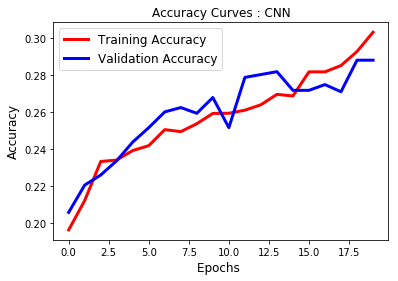

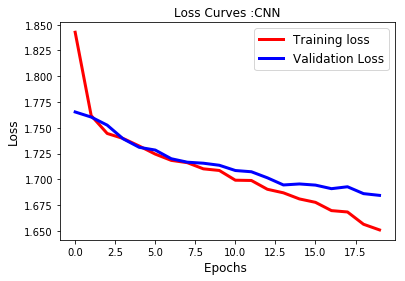

In [78]:
accu_curve=plt.figure()
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : CNN',fontsize=12)
accu_curve.savefig('accuracy_cnn_improved_v1.4.3.best.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :CNN',fontsize=12)
loss_curve.savefig('loss_cnn_improved_v1.4.3.best.png')
loss_curve.show()

## Use multi-convolutional CNN model for fake news classification

Let's do small modification on above CNN model, in this notebook I introduce multi convolutional CNN model for fake news classification. let's see how it works and see where is significancy.

In [91]:
statement_input = Input(shape=(num_steps,), dtype='int64', name='main_input')
embed_sequence = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings

## add multi convolutional layer
l_conv1 = Conv1D(128,4,activation="relu", padding="same", strides=1)(embed_sequence)
l_pool1 = MaxPooling1D(4)(l_conv1)
l_conv2 = Conv1D(128, 4, activation="relu")(l_pool1)
l_pool2 = MaxPooling1D(4)(l_conv2)
# l_conv3 = Conv1D(128,3,activation="relu")(l_pool2)
# l_pool3 = MaxPooling1D()(l_conv3)
l_flat = Flatten()(l_pool2)
conv_in = Dropout(0.9)(l_flat)
conv_in = Dense(128, activation='relu')(conv_in)

#Meta input
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_drop = Dropout(0.7)(meta_input)
x_meta = Dense(64, activation='relu')(x_drop)
x = keras.layers.concatenate([conv_in, x_meta])

main_output = Dense(6, activation='softmax', name='main_output')(x)
model_multi = Model(inputs=[statement_input, meta_input], outputs=[main_output])

#************************************************************************#
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_multi.compile(optimizer=sgd,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model_multi.summary()

tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history22= model_multi.fit({'main_input': x_train, 'aux_input': x_train_metadata},
                           {'main_output': y_train},epochs=18, batch_size=64,
                           validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
                           callbacks=[tb,csv_logger,checkpoint, es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 32, 300)      3722700     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 32, 128)      153728      embedding_36[0][0]               
__________________________________________________________________________________________________
max_pooling1d_93 (MaxPooling1D) (None, 8, 128)       0           conv1d_102[0][0]                 
__________________________________________________________________________________________________
conv1d_103

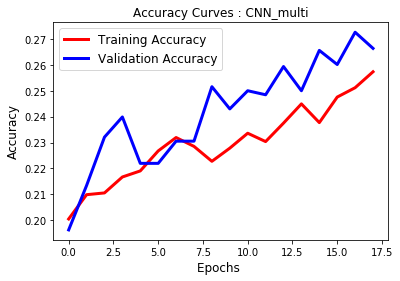

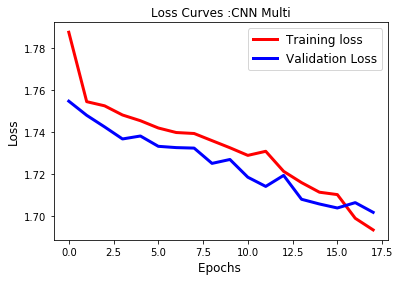

In [92]:
## to see performance difference
accu_curve=plt.figure()
plt.plot(history22.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history22.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : CNN_multi',fontsize=12)
accu_curve.savefig('accuracy_multi_conv_cnn.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history22.history['loss'],'r',linewidth=3.0)
plt.plot(history22.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :CNN Multi',fontsize=12)
loss_curve.savefig('loss_multi_conv_cnn.png')
loss_curve.show()

#### if we run the model multiple times (Experiment)

In [ ]:
kernel_arr = []
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
embed_sequences = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
# x = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch

# for kernel in kernel_sizes:
#     x_1 = Conv1D(filters=filter_size,kernel_size=kernel, 
#                  padding="same", activation="relu", strides=1)(embed_sequences)
#     x_1 = MaxPool1D(3)(x_1)
#     x_flat = Flatten()(x_1)
#     x_drop = Dropout(0.6)(x_flat)
#     kernel_arr.append(x_drop)

# conv_in = keras.layers.concatenate(kernel_arr)
# conv_in = Dropout(0.7)(conv_in)
# conv_in = Dense(128, activation='relu')(conv_in)

# #Meta input
# meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
# x_drop = Dropout(0.7)(meta_input)
# x_meta = Dense(100, activation='relu')(x_drop)
# x = keras.layers.concatenate([conv_in, x_meta])

# main_output = Dense(6, activation='softmax', name='main_output')(x)
# model = Model(inputs=[statement_input, meta_input], outputs=[main_output])

## add multi convolutional layer
l_conv1 = Conv1D(128,3,activation="relu", padding="same", strides=1)(embed_sequences)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128, 3, activation="relu")(l_pool1)
l_pool2 = MaxPooling1D(3)(l_conv2)
# l_conv3 = Conv1D(128,3,activation="relu")(l_pool2)
# l_pool3 = MaxPool1D(3)(l_conv3)
l_flat = Flatten()(l_pool2)
conv_in = Dropout(0.9)(l_flat)
conv_in = Dense(hidden_size, activation='relu')(conv_in)

#Meta input
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_drop = Dropout(0.8)(meta_input)
x_meta = Dense(64, activation='relu')(x_drop)
x = keras.layers.concatenate([conv_in, x_meta])

main_output = Dense(6, activation='softmax', name='main_output')(x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

####
runs=5
histArr = []

for i in range(runs):
    print('Running iteration %i/%i' % (i+1, runs))
    model_multirun = Model(inputs=[statement_input, meta_input], outputs=[main_output])
    model_multirun.compile(optimizer=sgd,
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])
    
    ####
    tb = TensorBoard()
    csv_logger = keras.callbacks.CSVLogger('training.log')
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    #filepath= "weights.best.hdf5"
    # checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
    #                                              monitor='val_categorical_accuracy', 
    #                                              verbose=1, save_best_only=True, mode='max')

    history22= model_multirun.fit({'main_input': x_train, 'aux_input': x_train_metadata},
                                  {'main_output': y_train},epochs=30, batch_size=100, verbose=1,
                                  validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
                                  callbacks=[keras.callbacks.ModelCheckpoint('model-%i.h5'%(i+1), 
                                                                              monitor='val_categorical_accuracy', verbose=1, 
                                                                              save_best_only=True, mode='max'), tb, csv_logger])
                       #callbacks=[tb,csv_logger,checkpoint, es])
    print()
    histArr.append(history22.history)

In [ ]:
### plot the output
with open('history22.pkl', 'wb') as f:
    cPickle.dump(histArr, f)

In [ ]:
histArr = cPickle.load(open('history22.pkl', 'rb'))

In [ ]:
def get_avg(histArr, his_key):
    tmp = []
    for history in histArr:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histArr, 'loss'),
                                              get_avg(histArr, 'categorical_accuracy')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histArr, 'val_loss'),
                                                get_avg(histArr, 'val_categorical_accuracy')))

In [ ]:
def plot_acc_loss(title, histArr, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histArr):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histArr:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

In [ ]:
plot_acc_loss('training', histArr, 'categorical_accuracy', 'loss')
plot_acc_loss('validation', histArr, 'val_categorical_accuracy', 'val_loss')

In [ ]:
### Make prediction
from keras.models import load_model
#Load a pre-trained model if any
model1 = load_model('weights.best.hdf5')
preds = model1.predict([x_test,x_test_metadata], batch_size=batch_size, verbose=1)
print(np.array(preds))

In [ ]:
# from keras.utils.np_utils import accuracy
# acc = accuracy(y_test, np.round(np.array(preds)))

###  C-LSTM model for fake news classification

To better understand performance gap between different convolutional models, here I want to see Convolutional -LSTM model for fake news classification. Note that I didn't run multiple convolutional filers for fake news texts because it raise strange error, so I'll proceed somehow simple but powerful model for fake news classification.

In [79]:
## C-LSTM model implementation (trail version)
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import LSTM, Bidirectional

statement_input = Input(shape=(num_steps,), dtype='int64', name='main_input')
# embed_layer = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch
embed_layer = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
l_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(embed_layer)
# lstm_pool = GlobalMaxPool1D()(l_lstm)

## let's add convolutional layer on it
l_conv1 = Conv1D(128, 3, activation="relu")(l_lstm)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128,3,activation="relu")(l_pool1)
l_pool2 = MaxPool1D(3)(l_conv2)
l_flat = Flatten()(l_pool2)
l_drop = Dropout(0.8)(l_flat)
conv_in = Dense(hidden_size, activation="relu")(l_drop)

### metadata
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_meta_hidden = Dense(64, activation='relu')(meta_input)
x_meta_reg = Dropout(0.6)(x_meta_hidden)

conv_final = keras.layers.concatenate([conv_in, x_meta_reg])
model_output = Dense(6, activation='softmax', name='main_output')(conv_final)
model_CLSTM = Model(inputs=[statement_input, meta_input], outputs=[model_output])

## compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_CLSTM.compile(optimizer=sgd,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model_CLSTM.summary()

tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history_clstm = model_CLSTM.fit({'main_input': x_train, 'aux_input': x_train_metadata},
                                {'main_output': y_train},epochs=num_epochs, batch_size=batch_size,
                                validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
                                callbacks=[tb,csv_logger,checkpoint, es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 32, 300)      3722700     main_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 200)      320800      embedding_30[0][0]               
__________________________________________________________________________________________________
conv1d_88 (Conv1D)              (None, 30, 128)      76928       bidirectional_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [ ]:
### Experimental modification on c-lstm model for fake news classification

"""
## let's add lstm
l_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(embed_layer)
lstm_pool = GlobalMaxPool1D()(l_lstm)
lstm_drop = Dropout(0.6)(lstm_pool)
lstm_dense = Dense(hidden_size, activation="relu")(lstm_drop)

## let's add convolutional layer
l_conv1 = Conv1D(128, 3, activation="relu")(embed_layer)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128,3,activation="relu")(l_pool1)
l_pool2 = MaxPool1D(3)(l_conv2)
l_flat = Flatten()(l_pool2)
l_drop = Dropout(0.6)(l_flat)
conv_in = Dense(hidden_size, activation="relu")(l_drop)

## merge lstm and convs
conv_ins = keras.layers.concatenate([conv_in, lstm_dense])

### metadata
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_meta_hidden = Dense(64, activation='relu')(meta_input)
x_meta_reg = Dropout(0.6)(x_meta_hidden)

conv_final = keras.layers.concatenate([conv_ins, x_meta_reg])
"""

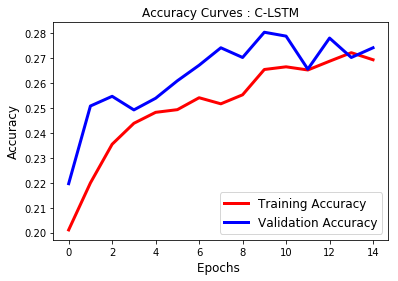

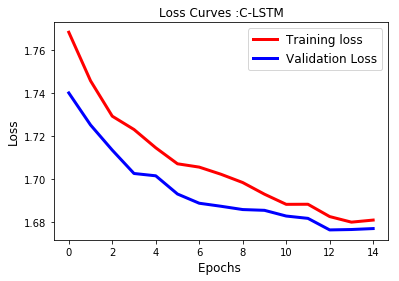

In [81]:
### visualize c-lstm model output
accu_curve=plt.figure()
plt.plot(history_clstm.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history_clstm.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : C-LSTM',fontsize=12)
accu_curve.savefig('accuracy_clstm_improved_v1.4.4.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history_clstm.history['loss'],'r',linewidth=3.0)
plt.plot(history_clstm.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :C-LSTM',fontsize=12)
loss_curve.savefig('loss_clstm_improved_v1.4.4.png')
loss_curve.show()

### Improvised version of C-LSTM model for fake news classification

In [84]:
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import LSTM, Bidirectional

##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++##
kernel_arr = []
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
embedded_sequences = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
# x = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch
x_lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.5))(embedded_sequences)

for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel, 
                 padding="valid", activation="relu", strides=1)(x_lstm)
    x_pool = MaxPool1D(4)(x_1)
    #x_pool = GlobalMaxPool1D()(x_1)
    x_flat = Flatten()(x_pool)
    x_drop = Dropout(0.85)(x_flat)
    kernel_arr.append(x_drop)

conv_in = keras.layers.concatenate(kernel_arr)
# conv_in = Dropout(0.7)(conv_in)
conv_in = Dense(128, activation='relu')(conv_in)

"""
## use bidirectional lstm
x_lstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x_1)
lstm_pool = GlobalMaxPool1D()(x_lstm)
lstm_dense = Dense(100, activation="relu")(lstm_pool)

## first concatenate
conv_ins= keras.layers.concatenate([conv_in, lstm_dense])
"""

#Meta input
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_drop = Dropout(0.8)(meta_input)
x_meta = Dense(64, activation='relu')(x_drop)
x = keras.layers.concatenate([conv_in,x_meta])

main_output = Dense(6, activation='softmax', name='main_output')(x)
model_clstm_ = Model(inputs=[statement_input, meta_input], outputs=[main_output])


## compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_clstm_.compile(optimizer=sgd,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])


model_clstm_.summary()

##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++##
tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history_clstm_ = model_clstm_.fit({'main_input': x_train, 'aux_input': x_train_metadata},
                                {'main_output': y_train},epochs=num_epochs, batch_size=64,
                                validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
                                callbacks=[tb,csv_logger,checkpoint, es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 32, 300)      3722700     main_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 32, 256)      439296      embedding_32[0][0]               
__________________________________________________________________________________________________
conv1d_93 (Conv1D)              (None, 30, 128)      98432       bidirectional_3[0][0]            
__________________________________________________________________________________________________
conv1d_94 

Epoch 13/30
10240/10240 [==============================] - 41s 4ms/step - loss: 1.6989 - categorical_accuracy: 0.2586 - val_loss: 1.6903 - val_categorical_accuracy: 0.2749

Epoch 00013: val_categorical_accuracy did not improve from 0.28193
Epoch 14/30
10240/10240 [==============================] - 41s 4ms/step - loss: 1.6984 - categorical_accuracy: 0.2589 - val_loss: 1.6901 - val_categorical_accuracy: 0.2734

Epoch 00014: val_categorical_accuracy did not improve from 0.28193
Epoch 15/30
10240/10240 [==============================] - 41s 4ms/step - loss: 1.6995 - categorical_accuracy: 0.2566 - val_loss: 1.6913 - val_categorical_accuracy: 0.2812

Epoch 00015: val_categorical_accuracy did not improve from 0.28193
Epoch 16/30
10240/10240 [==============================] - 40s 4ms/step - loss: 1.6953 - categorical_accuracy: 0.2564 - val_loss: 1.6915 - val_categorical_accuracy: 0.2866

Epoch 00016: val_categorical_accuracy improved from 0.28193 to 0.28660, saving model to weights.best.hdf5
E

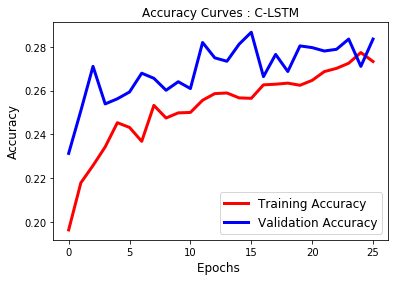

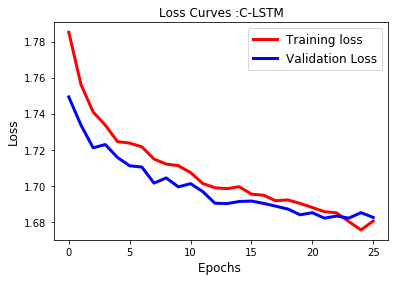

In [85]:
### visualize c-lstm model output
accu_curve=plt.figure()
plt.plot(history_clstm_.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history_clstm_.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : C-LSTM',fontsize=12)
accu_curve.savefig('accuracy_clstm_improved_v1.4.4.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history_clstm_.history['loss'],'r',linewidth=3.0)
plt.plot(history_clstm_.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :C-LSTM',fontsize=12)
loss_curve.savefig('loss_clstm_improved_v1.4.4.png')
loss_curve.show()

### Character level CNN model for fake news classification

In [ ]:
import tensorflow as tf
from keras import layers
from keras import backend as K
from math import sqrt
K.set_image_dim_ordering('th')

from keras import Model
from keras.layers import Input, Dense, Concatenate, Embedding, Flatten
from keras.layers import AlphaDropout
from keras.layers import ThresholdedReLU
from keras.callbacks import TensorBoard
from keras.layers import Convolution1D, GlobalMaxPooling1D

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras as K

#### character level classification (simple version)

In [ ]:
conv_layers=[[256, 7, 3],
             [256, 7, 3],
             [256, 3, -1],
             [256, 3, -1],
             [256, 3, -1],
             [256, 3, 3]]

fully_connected_layers=[1024, 1024]
dropout_p=0.5
threshold=1e-06
input_size=70
alphabet='abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{}'

batch_size=128
checkpoint_every=70
epochs=5000
# evaluate_every=100
batch_size=128
checkpoint_every=100
epochs=5000
# evaluate_every=100
embedding_size=128
alphabet_size=69

In [ ]:
## define model input, create embedding layer
sent_inputs = Input(shape=(input_size,), name='sent_input', dtype='int64')  # shape=(?, 1014)

conv = Embedding(alphabet_size+1, embedding_size, input_length=input_size, trainable=False)(sent_inputs)
# Conv 
conv_lay=[]
for filter_num, filter_size, pooling_size in conv_layers:
    x_conv = Conv1D(filter_num, filter_size, padding="same")(conv) 
    x_pool  = GlobalMaxPooling1D()(x_conv)
    x_drop = Dropout(0.6)(x_pool)
    conv_lay.append(x_drop)
#     if pooling_size != -1:
#         conv = MaxPooling1D(pool_size=pooling_size)(conv) # Final shape=(None, 34, 256)

# x = Flatten()(conv_lay) # (None, 8704)
x=concatenate(conv_lay)

# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = Dropout(dropout_p)(x)
    
model_output = Dense(6, activation='softmax')(x)
# Build model
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)

model_char = Model(inputs=sent_inputs, outputs=model_output)
model_char.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

model_char.summary()
tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es=EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=3 )
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')


# history_char= model_char.fit(x_train,y_train,epochs=num_epochs, batch_size=batch_size,
#                                validation_data=(x_val,y_val))

In [ ]:
x_train.shape

In [ ]:
model_char.fit(x_train,y_train,epochs=10, batch_size=64, validation_data=(x_val, y_val))


### Recurrent CNN model for fake news classification

In [ ]:
import gensim
import numpy as np
import string
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', limit= 500000,binary=True)
embeddings = np.zeros((word2vec.syn0.shape[0] + 1, word2vec.syn0.shape[1]), dtype = "float32")
embeddings[:word2vec.syn0.shape[0]] = word2vec.syn0

MAX_TOKENS = word2vec.syn0.shape[0]
embedding_dim = word2vec.syn0.shape[1]
hidden_dim_1 = 200
hidden_dim_2 = 100
NUM_CLASSES = 10

document = Input(shape = (None, ), dtype = "int32")
left_context = Input(shape = (None, ), dtype = "int32")
right_context = Input(shape = (None, ), dtype = "int32")

embedder = Embedding(MAX_TOKENS + 1, embedding_dim, weights = [embeddings], trainable = False)
doc_embedding = embedder(document)
l_embedding = embedder(left_context)
r_embedding = embedder(right_context)

forward = LSTM(hidden_dim_1, return_sequences = True)(l_embedding)
backward = LSTM(hidden_dim_1, return_sequences = True, go_backwards = True)(r_embedding)

# Keras returns the output sequences in reverse order.
backward = Lambda(lambda x: K.reverse(x, axes = 1))(backward)
together = concatenate([forward, doc_embedding, backward], axis = 2)

semantic = Conv1D(hidden_dim_2, kernel_size = 1, activation = "tanh")(together)

## define customized maxpooling layer
pool_rnn = Lambda(lambda x: K.max(x, axis = 1), output_shape = (hidden_dim_2, ))(semantic)
model_output = Dense(NUM_CLASSES, input_dim = hidden_dim_2, activation = "softmax")(pool_rnn)

model_RCNN = Model(inputs = [document, left_context, right_context], outputs = model_output)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_RCNN.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

model_RCNN.summary()

In [ ]:
# tb = TensorBoard()
# csv_logger = keras.callbacks.CSVLogger('training.log')
# filepath= "weights.best.hdf5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
#                                              monitor='val_categorical_accuracy', 
#                                              verbose=1, save_best_only=True, mode='max')

# history_rcnn= RCNN_model.fit({'main_input': x_train, 'aux_input': x_train_metadata},
#                              {'main_output': y_train},epochs=num_epochs, batch_size=batch_size,
#                              validation_data=({'main_input': x_val, 'aux_input': x_val_metadata},{'main_output': y_val}),
#                              callbacks=[tb,csv_logger,checkpoint])

In [ ]:
text = "This is some example text."
text = text.strip().lower().translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
tokens = text.split()
# tokens = [voca[token].index if token in word2vec.vocab else MAX_TOKENS for token in tokens]

doc_as_array = np.array([tokens])
# We shift the document to the right to obtain the left-side contexts.
left_context_as_array = np.array([[MAX_TOKENS] + tokens[:-1]])
# We shift the document to the left to obtain the right-side contexts.
right_context_as_array = np.array([tokens[1:] + [MAX_TOKENS]])

target = np.array([NUM_CLASSES * [0]])
target[0][3] = 1

history33 = model_RCNN.fit([doc_as_array, left_context_as_array, right_context_as_array], target, epochs = 1, verbose = 0)
loss = history33.history["loss"][0]